<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**DEAP_GE code running parity problems with 3, 4 or 5 bits**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Clone this repository in which we have all functions and classes created or adapted to this work.

In [2]:
!git clone https://github.com/danozu/deap_ge.git

Cloning into 'deap_ge'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 2), reused 14 (delta 2), pack-reused 0
Unpacking objects: 100% (14/14), done.


In [3]:
!pwd

%cd /content/deap_ge

/content
/content/deap_ge


Import adapted functions and classes from PonyGE2.

Import our algorithms, adapted from deap.algorithms.

Import DEAP (maybe it can be necessary to run the installation before that).

Import functions used by our grammars.



In [4]:
!pip install deap

from ponyge2_adapted_files import Grammar, ge
import algorithms
from functions import not_, and_, or_, nand_, nor_

from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deap import creator, base, tools

     |████████████████████████████████| 160 kB 2.7 MB/s 


Set our Grammatical Evolution parameters.

In [5]:
POPULATION_SIZE = 1000
MAX_GENERATIONS = 50
P_CROSSOVER = 0.8
P_MUTATION = 0.01
ELITE_SIZE = round(0.01*POPULATION_SIZE)

HALL_OF_FAME_SIZE = 1
MAX_INIT_TREE_DEPTH = 10
MIN_INIT_TREE_DEPTH = 1
MAX_TREE_DEPTH = 17
MAX_WRAPS = 0
CODON_SIZE = 255

Set a problem to solve. We can choose 'parity3', 'parity4' or 'parity5'.

The parameters in the previous cell are recommended to solve the problem with 3 bits. 

In [6]:
problem = 'parity3'

Read datasets and grammars according to the problem picked in the previous cell.

In [7]:
if problem == 'parity3':
    X = np.zeros([3,8], dtype=bool)
    Y = np.zeros([8,], dtype=bool)

    data = pd.read_table(r"datasets/parity3.csv")
    for i in range(3):
        for j in range(8):
            X[i,j] = data['d'+ str(i)].iloc[j]
    for i in range(8):
        Y[i] = data['output'].iloc[i]
        
    GRAMMAR_FILE = 'parity3.bnf'

elif problem == 'parity4':
    X = np.zeros([4,16], dtype=bool)
    Y = np.zeros([16,], dtype=bool)

    data = pd.read_table(r"datasets/parity4.csv")
    for i in range(4):
        for j in range(16):
            X[i,j] = data['d'+ str(i)].iloc[j]
    for i in range(16):
        Y[i] = data['output'].iloc[i]
        
    GRAMMAR_FILE = 'parity4.bnf'

elif problem == 'parity5':
    X = np.zeros([5,32], dtype=bool)
    Y = np.zeros([32,], dtype=bool)

    data = pd.read_table(r"datasets/parity5.csv")
    for i in range(5):
        for j in range(32):
            X[i,j] = data['d'+ str(i)].iloc[j]
    for i in range(32):
        Y[i] = data['output'].iloc[i]
        
    GRAMMAR_FILE = 'parity5.bnf'

Print data.

In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(data)

,d0,d1,d2,output
0,0,0,0,1
1,0,0,1,0
2,0,1,0,0
3,0,1,1,1
4,1,0,0,0
5,1,0,1,1
6,1,1,0,1
7,1,1,1,0


Print grammar.

In [9]:
f = open("grammars/" + GRAMMAR_FILE, "r")
print(f.read())
f.close() 

<e>  ::=  and_(<e>,<e>)|
          or_(<e>,<e>)|
          nand_(<e>,<e>)|
          nor_(<e>,<e>)|
          x[0]|x[1]|x[2]



Set up the grammar addressed by GRAMMAR_FILE in the class Grammar.

In [10]:
BNF_GRAMMAR = Grammar(path.join("grammars", GRAMMAR_FILE))

Define as fitness function the number of outputs wrongly predicted.

In [11]:
def fitness_eval(individual):
    x = X # It is necessary since the inputs are in X, but the grammar uses x
    
    if individual.invalid == True:
        return np.NaN,

    # Evaluate the expression
    try:
        pred = eval(individual.phenotype)
    except (FloatingPointError, ZeroDivisionError, OverflowError,
            MemoryError):
        # FP err can happen through eg overflow (lots of pow/exp calls)
        # ZeroDiv can happen when using unprotected operators
        return np.NaN,
    assert np.isrealobj(pred)

    # The expected outputs are in Y
    n_samples = len(Y)
    compare = np.equal(Y,pred) # Compare the outputs with the expected values
    n_correct_outputs = np.sum(compare)
    
    fitness = n_samples - n_correct_outputs
    
    return fitness,

Create the deap toolbox.

Use negative weights in the `base.Fitness` since we are trying to minimise the fitness.

`ge.Individual` is a class with the following attributes: `phenotype`, `genome`, `tree`, `nodes`, `invalid` (True or False), `depth` and `used_codons`.

Usually, when using deap, we initialise each individual independently, and then we repeat that until we fill out the whole population. However, since we are using Position Independent Grow Initialisation, we need to initialise all individuals simultaneously.

`ge.selTournament` prevents selecting invalid individuals.

`ge.crossover_onepoint` selects crossover points within the used portion of the genome. 

Similarly, `ge.mutation_int_flip_per_codon` performs only over the effective length.



In [12]:
toolbox = base.Toolbox()

# define a single objective, minimising fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create('Individual', ge.Individual, fitness=creator.FitnessMin)

toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 

toolbox.register("evaluate", fitness_eval)

# Tournament selection:
toolbox.register("select", ge.selTournament, tournsize=7)

# Single-point crossover:
toolbox.register("mate", ge.crossover_onepoint)

# Flip-int mutation:
toolbox.register("mutate", ge.mutation_int_flip_per_codon)


Set the main function and run it.

Set the statistics object regarding the fitness score, but there are other statistics defined internally.

Perform Grammatical Evolution using `algorithms.ge_eaSimple`, a simple evolutionary algorithm. The differences to the `algorithms.eaSimple` used by deap are:

*   We use elitism;
*   After crossover and mutation, we check the offspring to assure that the max tree depth is not achieved;
*   We measure the generation and the selection times;
*   We count the number of invalid individuals.

In [14]:
# create initial population (generation 0):
population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                        bnf_grammar=BNF_GRAMMAR, 
                                        min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                        max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                        max_tree_depth=MAX_TREE_DEPTH, 
                                        max_wraps=MAX_WRAPS,
                                        codon_size=CODON_SIZE
                                        )

# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

# prepare the statistics object:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

# perform the Grammatical Evolution flow:
population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                          bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE, 
                                          max_tree_depth=MAX_TREE_DEPTH, max_wraps=MAX_WRAPS,
                                          stats=stats, halloffame=hof, verbose=True)

gen	invalid	avg  	std     	min	max	selection_time	generation_time
0  	0      	4.012	0.523313	2  	6  	0             	0.178363       
1  	0      	3.87477	0.562531	2  	6  	0.0162311     	2.95533        
2  	449    	3.65394	0.591147	2  	6  	0.0207162     	1.07277        
3  	188    	3.58581	0.65421 	2  	5  	0.0139306     	0.350112       
4  	126    	3.61326	0.680137	2  	6  	0.013927      	0.306095       
5  	95     	3.5778 	0.701457	2  	6  	0.0138822     	0.362042       
6  	81     	3.49465	0.769795	2  	6  	0.0138903     	0.347881       
7  	66     	3.38737	0.83063 	2  	6  	0.0123219     	0.346557       
8  	50     	3.30721	0.906081	2  	6  	0.0136292     	0.31705        
9  	43     	3.33195	0.958521	2  	6  	0.0135727     	0.323747       
10 	33     	3.28482	0.960746	2  	6  	0.0139289     	0.377358       
11 	38     	3.30462	0.980073	2  	6  	0.0145788     	0.315863       
12 	25     	3.24127	0.986719	2  	6  	0.0150623     	0.279997       
13 	26     	3.18673	1.01661 	1  	6  	0.0135331     	

Show the best individual as an expression.

Improve:
Show depth etc.
Other runs

In [28]:
print("Best individual: ")
print(hof.items[0].phenotype)
print()
print("Training Fitness: ", hof.items[0].fitness.values[0])
print()
print("Depth: ", hof.items[0].depth)
print()
print("Length of the genome: ", len(hof.items[0].genome))
print()
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')
print()

Best individual: 
and_(nor_(nor_(x[0],or_(nor_(x[1],and_(or_(nor_(x[1],x[0]),x[1]),x[2])),x[2])),and_(nand_(nand_(x[0],x[1]),or_(x[0],x[1])),x[2])),or_(or_(nor_(x[1],x[0]),x[1]),x[2]))

Training Fitness:  0.0

Depth:  10

Length of the genome:  45

Used portion of the genome: 0.69



Extract statistics to plot graphs regarding the best fitness and the average fitness.

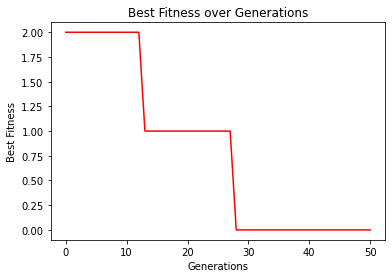

In [29]:
# Extract statistics to plot graphs:
min_fitness_values = logbook.select("min")
mean_fitness_values = logbook.select("avg")
std_fitness_values = logbook.select("std")

plt.plot(min_fitness_values, color='red')
plt.xlabel('Generations')
plt.ylabel('Best Fitness')
#plt.title('Max and Average Fitness over Generations')
plt.title('Best Fitness over Generations')
plt.show()


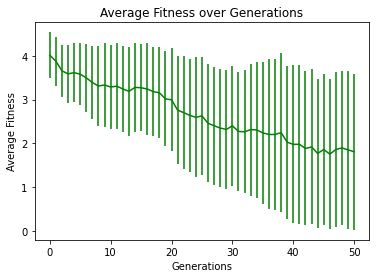

In [30]:
gen = np.arange(0, 50+1)

plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()